In [1]:
#Imports
import requests
import networkx as nx
import matplotlib.pyplot as plt
import csv
from math import pi, sqrt
from tabulate import tabulate
import numpy as np

First we use the fandom wiki API to extract links from the characters, and create a directed graph based on which links in the character wikipedia pages are refferenced. The names are taken from the "characters_v4.csv" file, and used for getting the wiki URLs.


In [2]:
# Function to fetch links from a character's Game of Thrones Fandom Wiki page
def get_character_links(character_name):
    base_url = "https://gameofthrones.fandom.com/api.php"
    params = {
        "action": "parse",
        "page": character_name,
        "prop": "links",
        "format": "json",
    }

    response = requests.get(base_url, params=params)
    data = response.json()

    links = []

    if "parse" in data and "links" in data["parse"]:
        links = [link["*"] for link in data["parse"]["links"] if link["*"] in character_names]

    return links

# Load the CSV file with the Game of Thrones characters' names
character_names = []

with open("characters_v4.csv", "r") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        character_names.append(row[0])

# Create a directed NetworkX graph
G = nx.DiGraph()

for character_name in character_names:
    G.add_node(character_name)

# Populate the graph with directed edges between characters
for character_name in character_names:
    character_links = get_character_links(character_name)
    for link in character_links:
        G.add_edge(character_name, link)


Then we can draw the graph, with highlighting of the most well connected characters

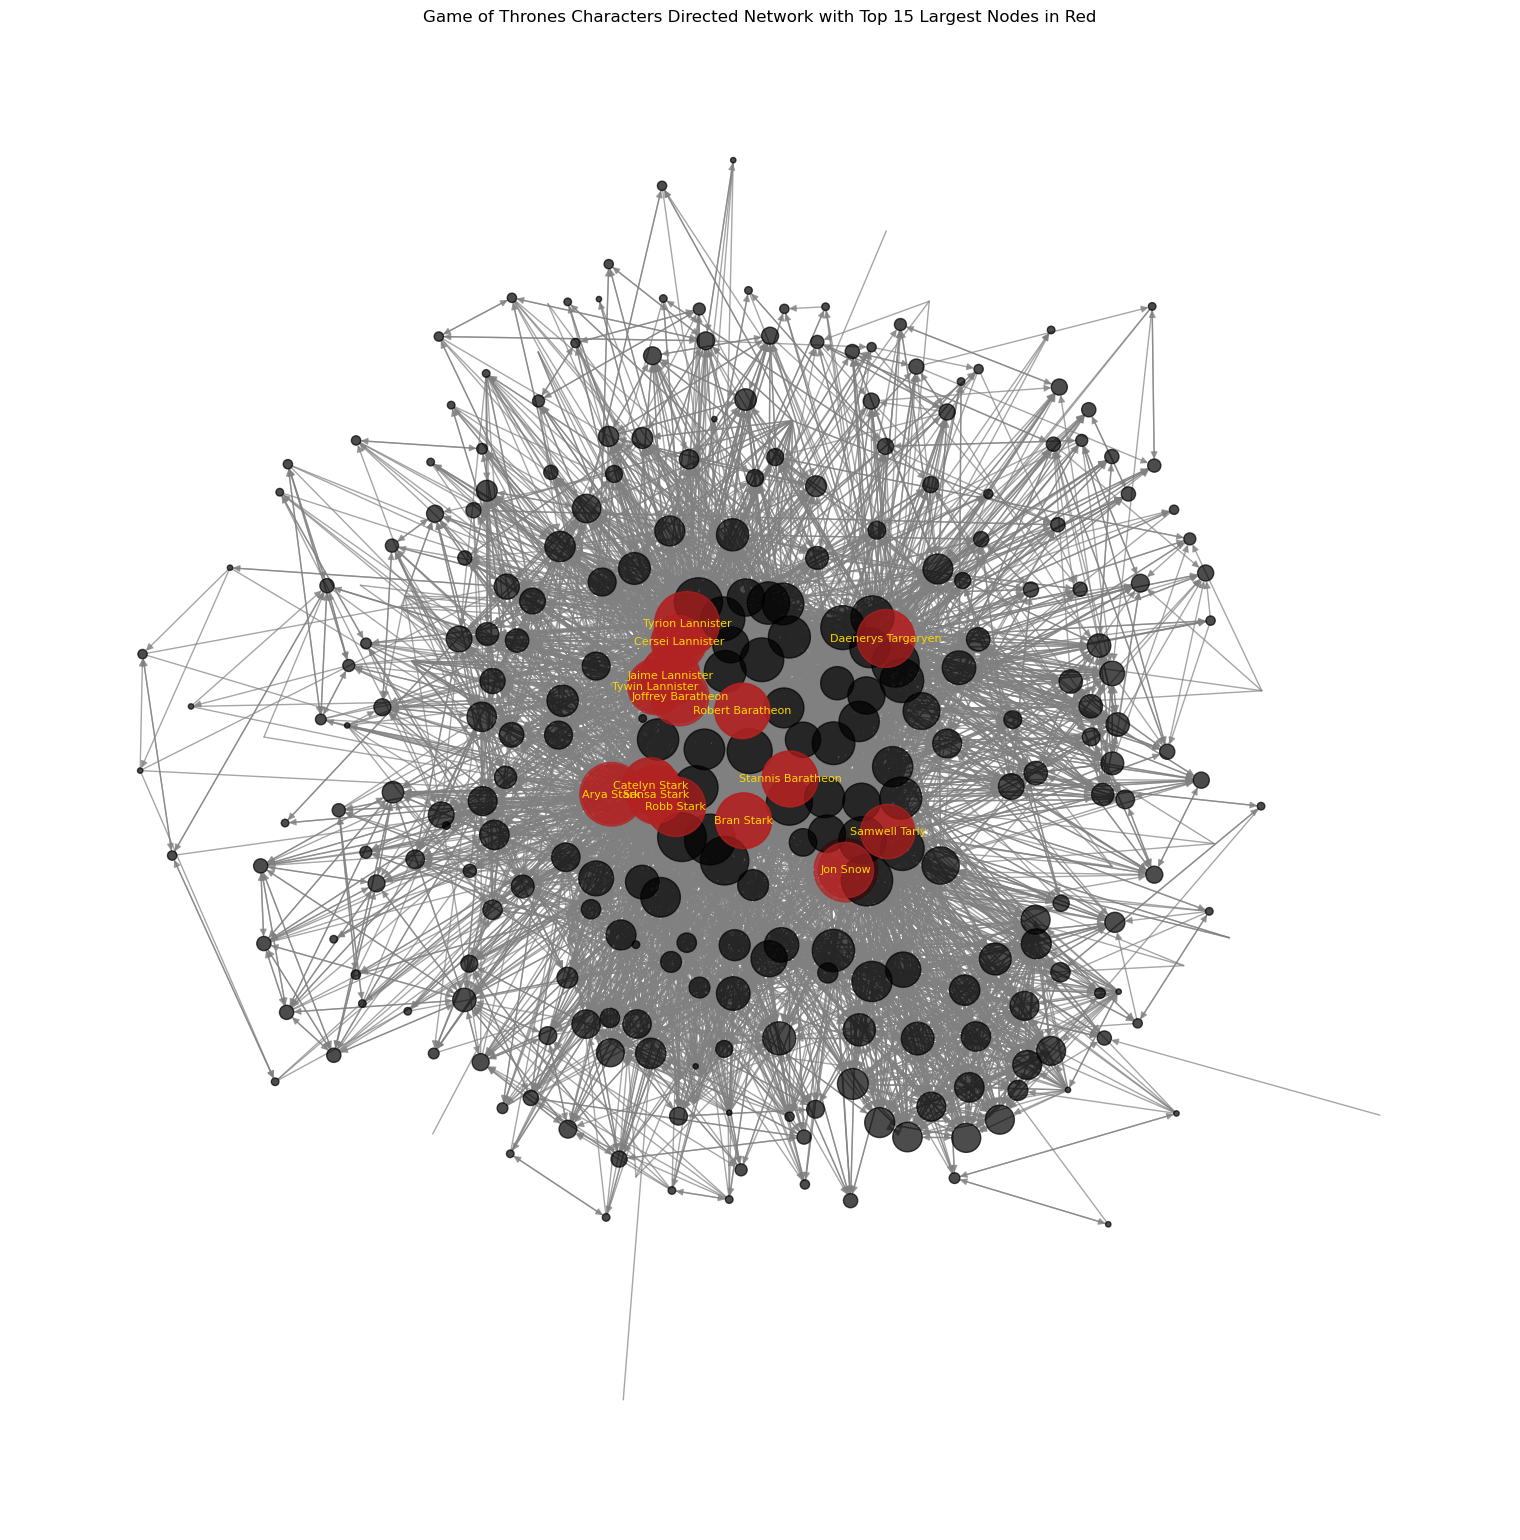

In [11]:
# Calculate in-degrees
in_degrees = G.in_degree()

# Determine the 15 nodes with the highest in-degrees
top_15_nodes = sorted(in_degrees, key=lambda x: x[1], reverse=True)[:15]

# Create a list of labels for the 15 biggest nodes
node_labels = {}
for node, in_degree in top_15_nodes:
    node_labels[node] = node

# Calculate node sizes based on in-degrees
node_sizes = [in_degree * 15 for _, in_degree in in_degrees]

# Use the Kamada-Kawai layout algorithm for node positioning
pos = nx.kamada_kawai_layout(G)

# Increase the figure size for better visualization
plt.figure(figsize=(15, 15))

# Specify a different color for the 15 largest nodes
node_colors = ["firebrick" if node in [node for node, _ in top_15_nodes] else "black" for node in G.nodes()]

# Remove self loops
G.remove_edges_from(nx.selfloop_edges(G))

# Draw nodes with sizes and labels for all nodes except the top 15
nx.draw(G, 
        pos=pos, 
        with_labels=False, 
        node_size=node_sizes, 
        node_color=node_colors, 
        edge_color="grey", 
        font_size=10, 
        alpha=0.7,
        arrows=True
    )

# Draw labels for the 15 largest nodes
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='gold')

# Extract information for the top 15 nodes
top_15_node_list = [node for node, _ in top_15_nodes]
top_node_sizes = [size for node, size in zip(G.nodes(), node_sizes) if node in top_15_node_list]

# Draw the top 15 nodes again to ensure they're on top
nx.draw_networkx_nodes(G, 
                       pos, 
                       nodelist=top_15_node_list, 
                       node_size=top_node_sizes, 
                       node_color="firebrick", 
                       alpha=0.7
                      )

plt.title("Game of Thrones Characters Directed Network with Top 15 Largest Nodes in Red")
plt.show()


Analysing the in and out degree of the 5 most connected characters

In [4]:
def in_out_degrees(G):
    nodes = [node for node in G.nodes()]
    in_degrees = dict(G.in_degree(nodes))
    out_degrees = dict(G.out_degree(nodes))

    in_degrees = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)[:5]
    out_degrees = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)[:5]

    return in_degrees, out_degrees

print('Top 5 most connected nodes (characters):\n')
in_degrees, out_degrees = in_out_degrees(G)
in_table = tabulate(in_degrees, headers=['Character', 'In Degree'], tablefmt="presto")
out_table = tabulate(out_degrees, headers=['Character', 'Out Degree'], tablefmt="presto")

table = tabulate([list(item) for item in zip(str(in_table).splitlines(), str(out_table).splitlines())],
                        ["In Degree", "Out Degree"], tablefmt="presto")
print(table)

Top 5 most connected nodes (characters):

 In Degree                        | Out Degree
----------------------------------+-----------------------------------
 Character        |   In Degree   | Character        |   Out Degree
 ------------------+------------- | ------------------+--------------
 Tyrion Lannister |         145   | Jon Snow         |          125
 Jon Snow         |         140   | Sansa Stark      |           97
 Sansa Stark      |         122   | Tyrion Lannister |           91
 Arya Stark       |         121   | Jaime Lannister  |           91
 Robb Stark       |         117   | Robb Stark       |           90


And seeing their degree distribution

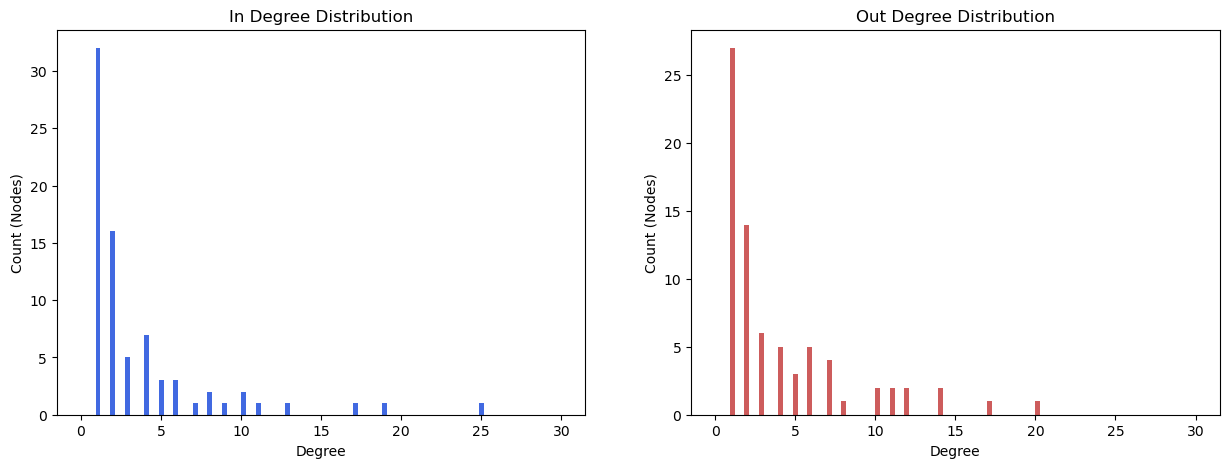

In [6]:
# In degree distribution
in_degrees = dict(G.in_degree())
in_values = sorted(set(in_degrees.values()))
in_hist = [list(in_degrees.values()).count(x) for x in in_values]

# Out degree distribution
out_degrees = dict(G.out_degree())
out_values = sorted(set(out_degrees.values()))
out_hist = [list(out_degrees.values()).count(x) for x in out_values]

# Bins
bins = np.linspace(0, 30, 100)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(in_hist, bins=bins, color='royalblue')
plt.title("In Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")

plt.subplot(1, 2, 2)
plt.hist(out_hist, bins=bins, color='indianred')
plt.title("Out Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count (Nodes)")
plt.show()